In [1]:
# Pip install method (recommended)

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.8/107.7 GB disk)


In [4]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [5]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


## Captureing pictures from the webcam

Here are the functions to capture a photo from the webcam on your device.
You're free to use them, or create your own version.

In [6]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [7]:
%ls {HOME}/drive

MyDrive/  Shareddrives/


In [8]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

def take_photo(filename='/content/photos/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

In [9]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

Run the following code block, the streaming video is on from the webcam until you hit the "capture" button to take a screenshot.
You may want to modify the code, to save the photo to a specific directory, with a specific filename (i.e. {HOME}/screenshots/photo_i.jpg)

In [10]:
%ls


drive/


In [11]:
try:
  filename = take_photo('/content/photos/photo.jpg')
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

[Errno 2] No such file or directory: '/content/photos/photo.jpg'


##Object detection on the captured picture, with pre-trained model;

In [12]:
%cd /content/{HOME}
%ls

[Errno 2] No such file or directory: '/content//content'
/content
drive/


After prediction, the log should say something like "Results saved to runs/detect/predict4'. You can view the results with the following code.

In [13]:
%cd {HOME}
!yolo task=detect mode=predict model=/content/drive/MyDrive/ECEN250/best.pt conf=0.25 source= /content/photos/photo.jpg save=True

# !yolo task=detect mode=predict model={HOME}/runs/detect/train2/weights/best.pt conf=0.25 source=newPhotos save=True

import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/photo.jpg'):
      display(Image(filename=image_path, width=600))
      print("\n")

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11127906 parameters, 0 gradients, 28.4 GFLOPs

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 445, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 242, in predict
    return self.predictor.predict_cli(source=source) if is_cli else self.predictor(source=source, stream=stream)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/predictor.py", line 205, in predict_cli
    for _ in gen:  # running CLI inference without accumulating any outputs (do not modify)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 35, in generator_context
    response = gen.send(Non

In [14]:
# Pip install method (recommended)

!pip install ultralytics==8.0.196

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO

from IPython.display import display, Image


import os
HOME = os.getcwd()
print(HOME)


%mkdir photos
%mkdir runs

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 28.8/107.7 GB disk)


/content


/content
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<IPython.core.display.Javascript object>

Saved to /content/photos/photo0.jpg


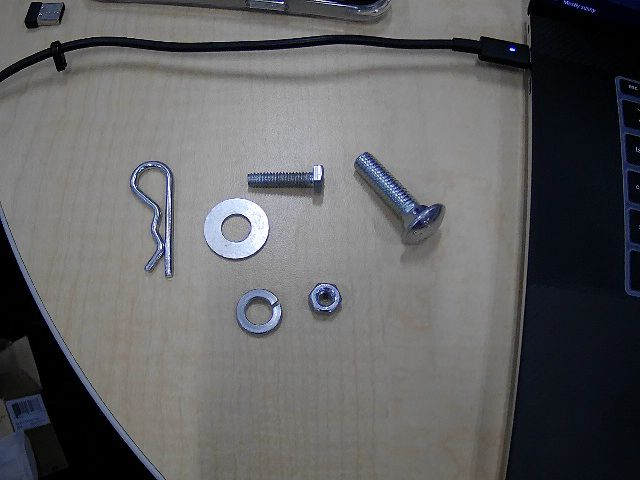

<IPython.core.display.Javascript object>

Saved to /content/photos/photo1.jpg


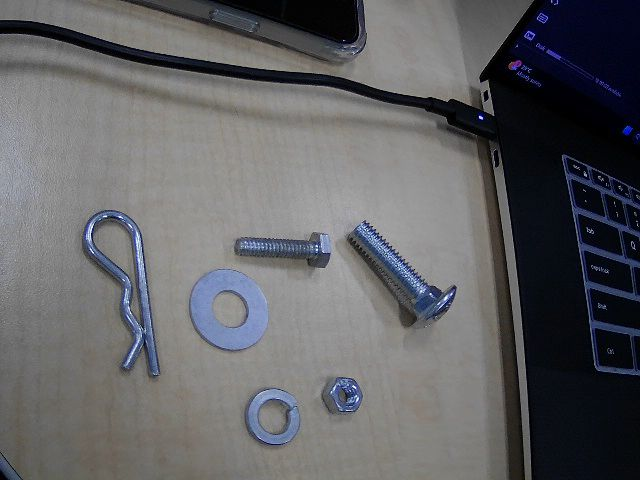

<IPython.core.display.Javascript object>

Saved to /content/photos/photo2.jpg


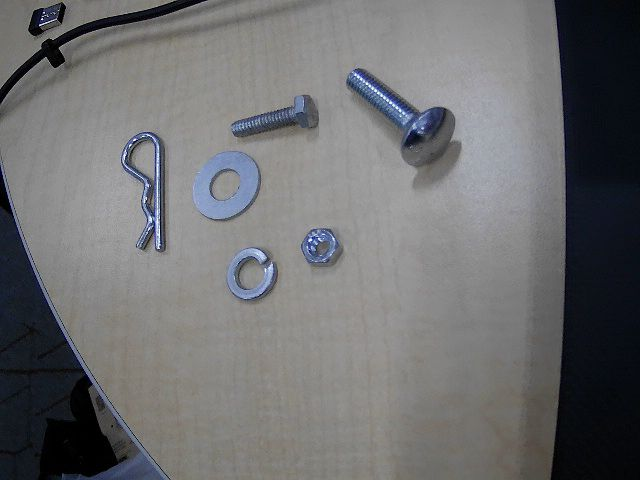

<IPython.core.display.Javascript object>

Saved to /content/photos/photo3.jpg


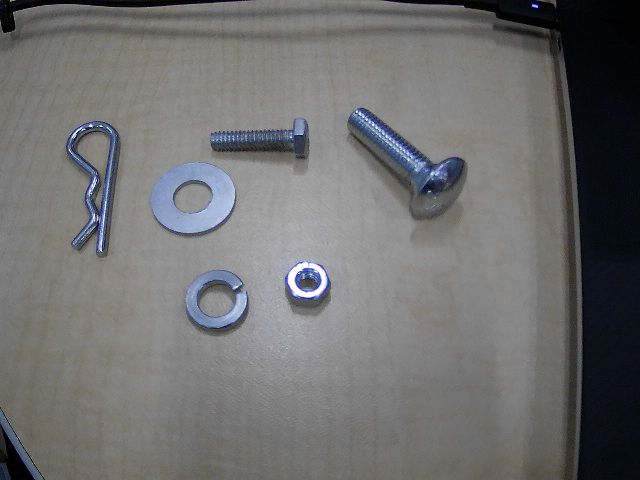

<IPython.core.display.Javascript object>

Saved to /content/photos/photo4.jpg


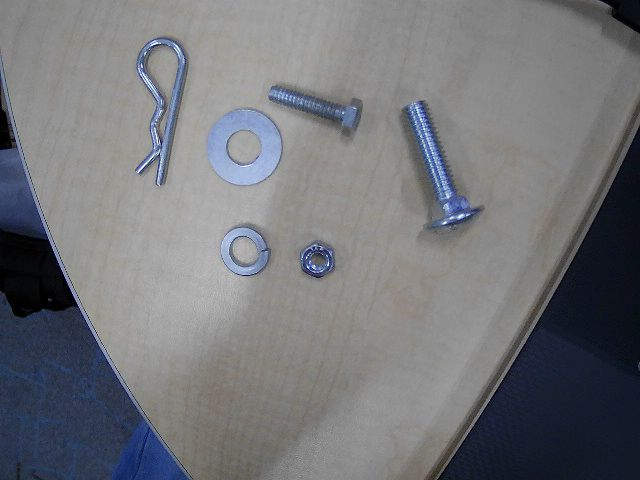

<IPython.core.display.Javascript object>

Saved to /content/photos/photo5.jpg


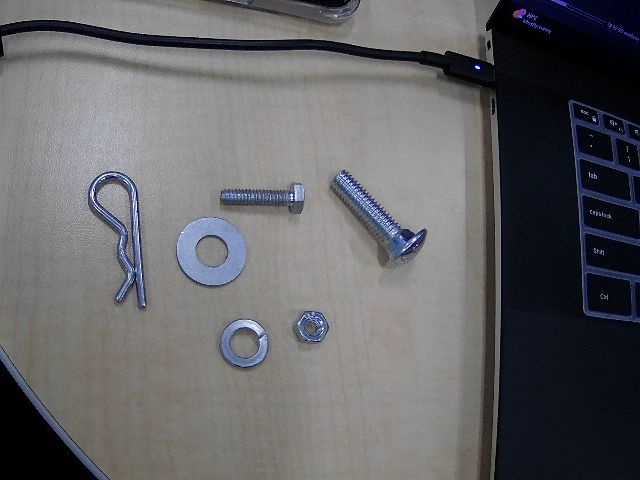

<IPython.core.display.Javascript object>

Saved to /content/photos/photo6.jpg


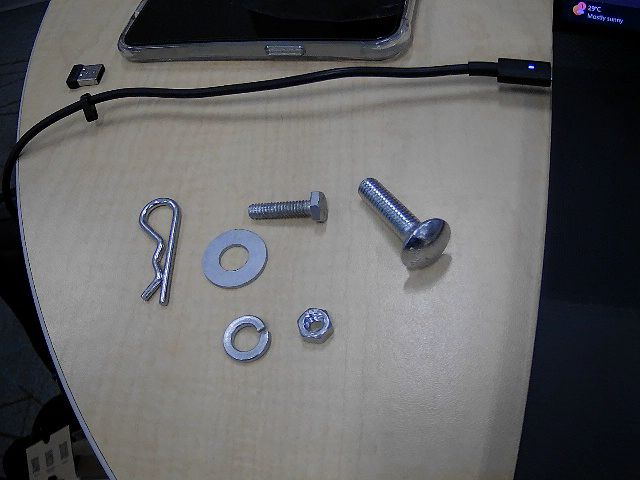

<IPython.core.display.Javascript object>

Saved to /content/photos/photo7.jpg


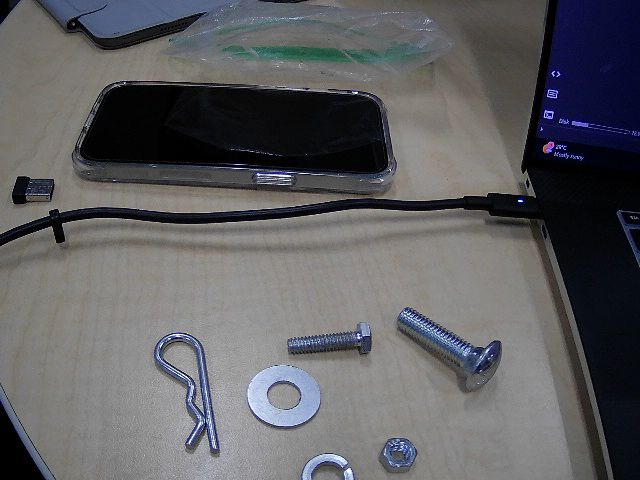

<IPython.core.display.Javascript object>

Saved to /content/photos/photo8.jpg


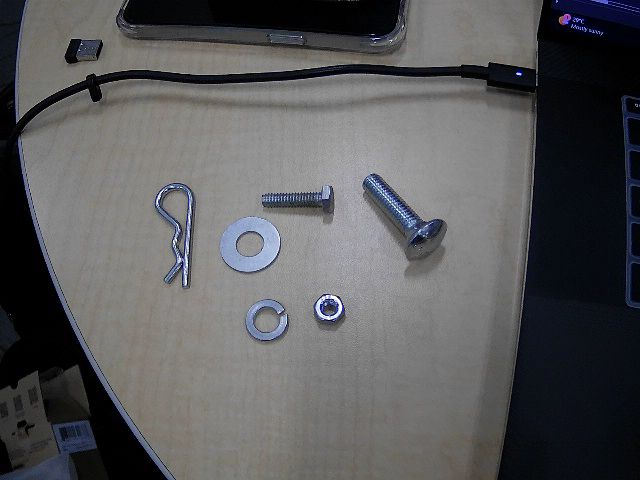

<IPython.core.display.Javascript object>

Saved to /content/photos/photo9.jpg


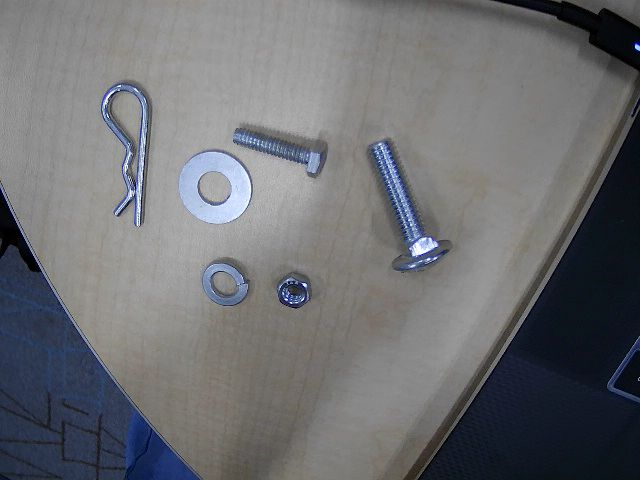

<IPython.core.display.Javascript object>

Saved to /content/photos/photo10.jpg


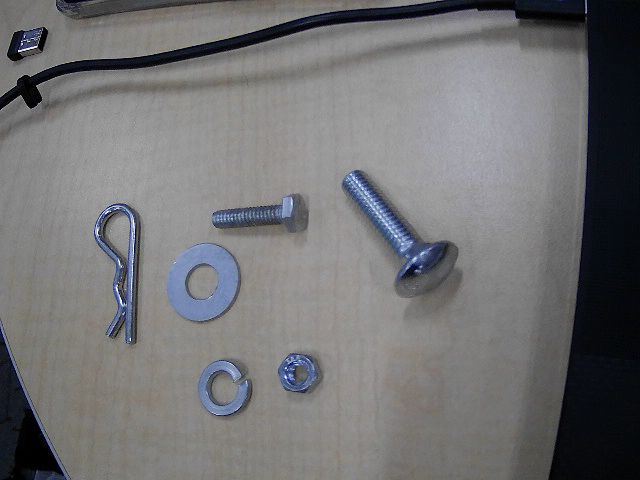

<IPython.core.display.Javascript object>

Saved to /content/photos/photo11.jpg


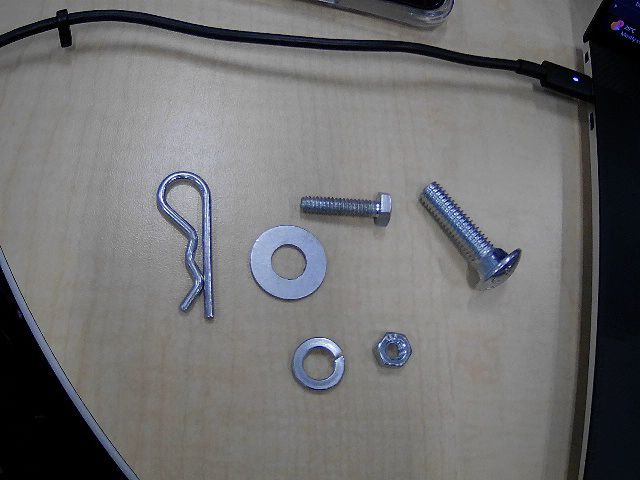

<IPython.core.display.Javascript object>

Saved to /content/photos/photo12.jpg


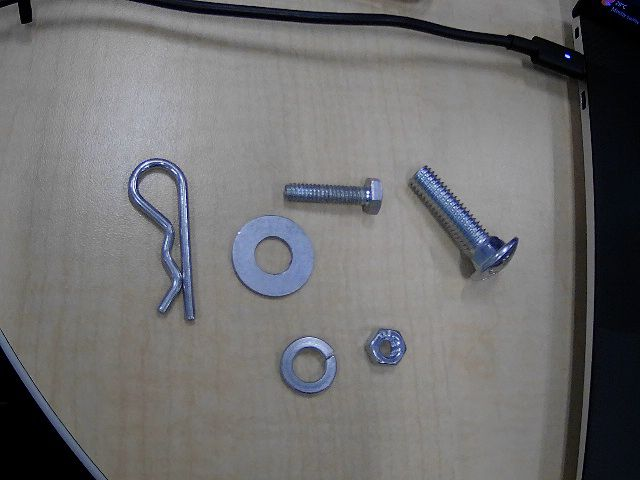

<IPython.core.display.Javascript object>

Saved to /content/photos/photo13.jpg


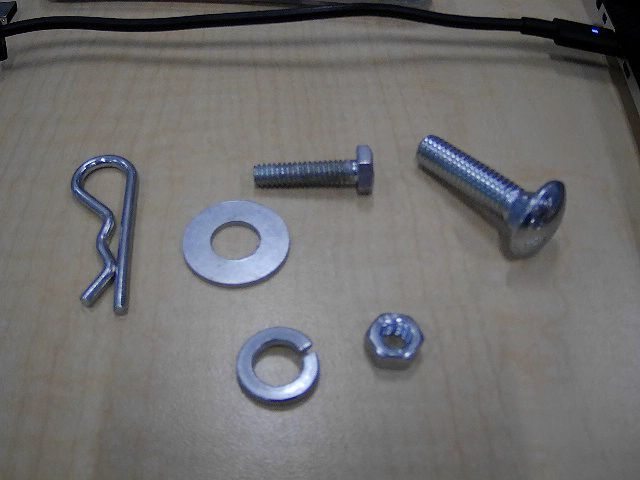

<IPython.core.display.Javascript object>

Saved to /content/photos/photo14.jpg


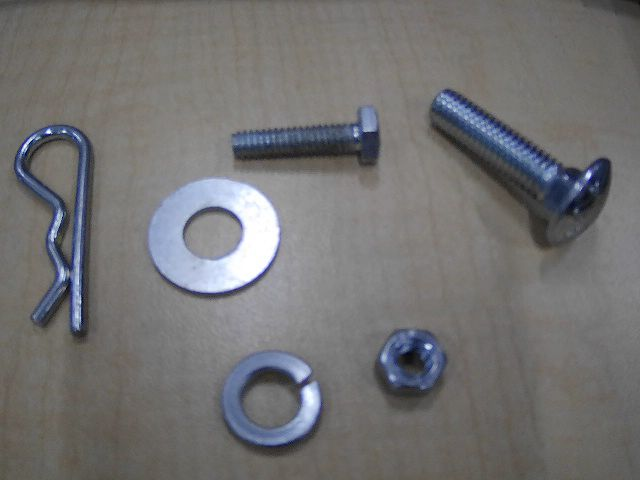

<IPython.core.display.Javascript object>

Saved to /content/photos/photo15.jpg


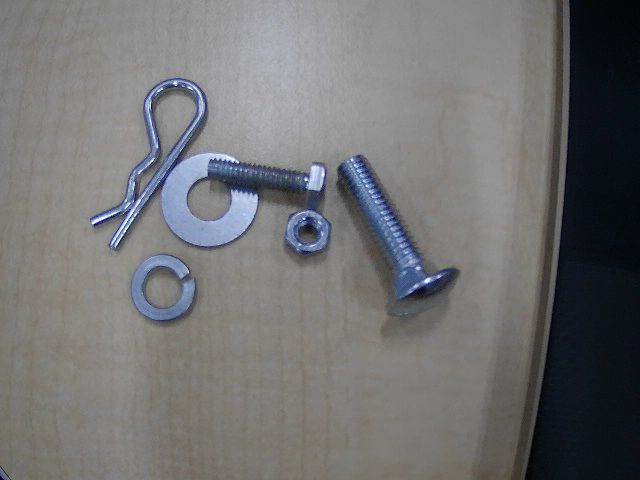

<IPython.core.display.Javascript object>

Saved to /content/photos/photo16.jpg


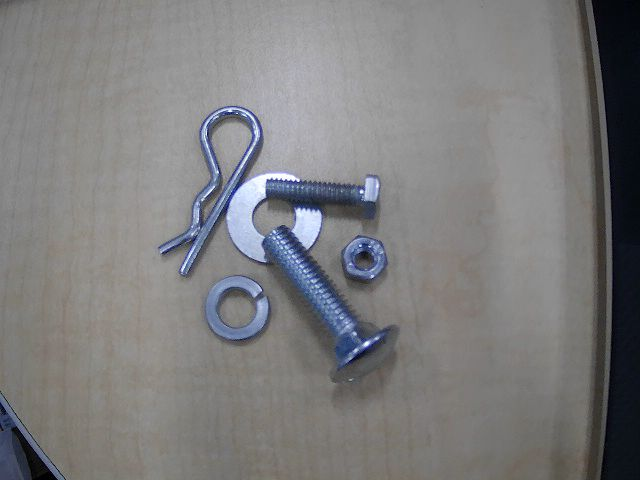

<IPython.core.display.Javascript object>

Saved to /content/photos/photo17.jpg


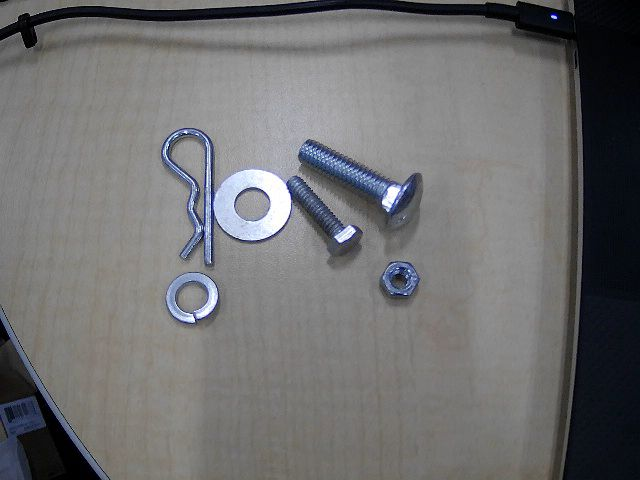

<IPython.core.display.Javascript object>

Saved to /content/photos/photo18.jpg


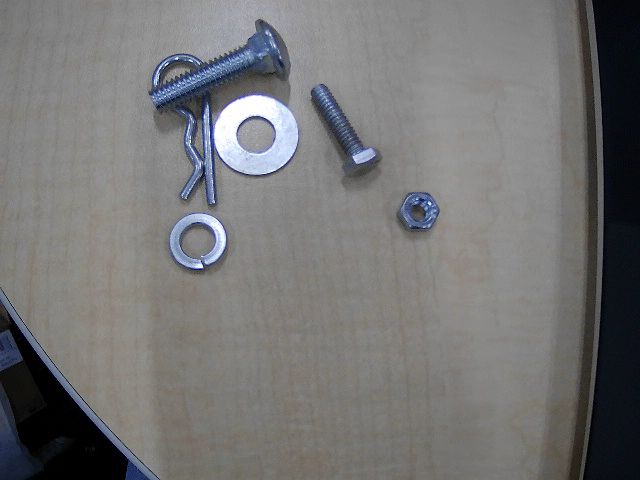

<IPython.core.display.Javascript object>

Saved to /content/photos/photo19.jpg


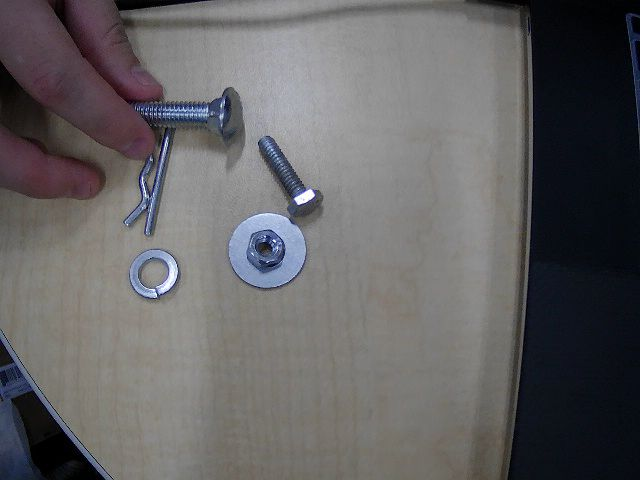

/content
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11127906 parameters, 0 gradients, 28.4 GFLOPs

image 1/20 /content/photos/photo0.jpg: 608x800 1 Carriage Bolt, 1 Hex Bolt, 1 Nut, 1 R Clip, 1 Split Washer, 1 Washer, 1007.4ms
image 2/20 /content/photos/photo1.jpg: 608x800 1 Carriage Bolt, 1 Hex Bolt, 1 Nut, 1 R Clip, 1 Split Washer, 1 Washer, 785.3ms
image 3/20 /content/photos/photo10.jpg: 608x800 1 Carriage Bolt, 1 Hex Bolt, 1 Nut, 1 R Clip, 1 Split Washer, 1 Washer, 806.6ms
image 4/20 /content/photos/photo11.jpg: 608x800 1 Carriage Bolt, 1 Hex Bolt, 1 Nut, 1 R Clip, 1 Split Washer, 1 Washer, 834.0ms
image 5/20 /content/photos/photo12.jpg: 608x800 1 Carriage Bolt, 1 Hex Bolt, 1 Nut, 1 R Clip, 1 Split Washer, 1 Washer, 1247.5ms
image 6/20 /content/photos/photo13.jpg: 608x800 1 Carriage Bolt, 1 Hex Bolt, 1 Nut, 1 R Clip, 1 Split Washer, 1 Washer, 1157.2ms
image 7/20 /content/photos/photo14.jpg: 608x800 1 Carri

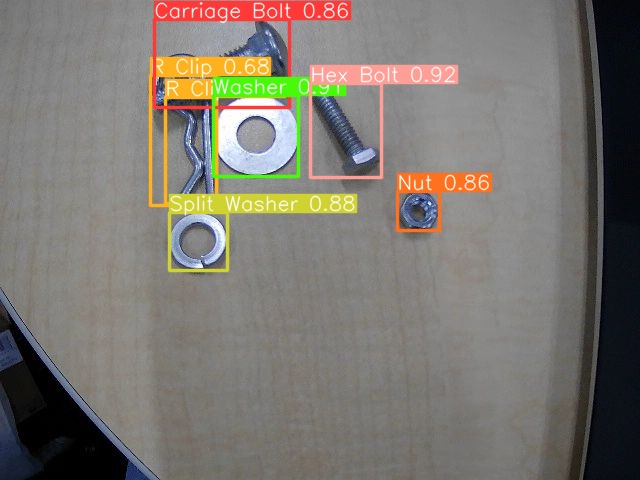

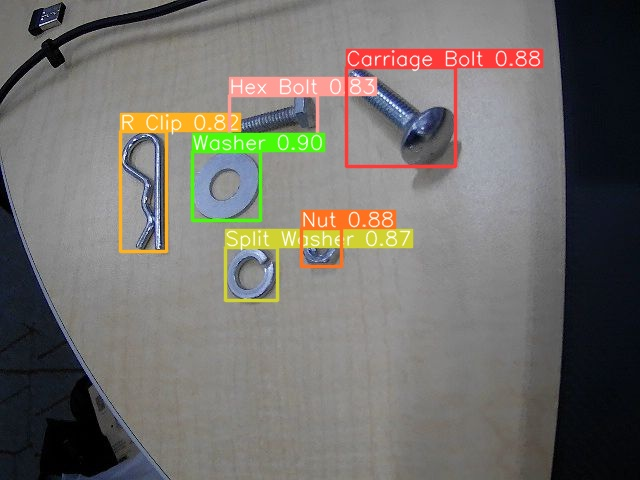

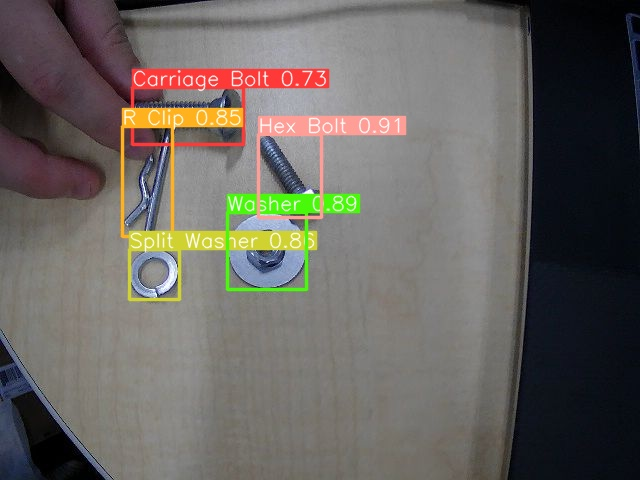

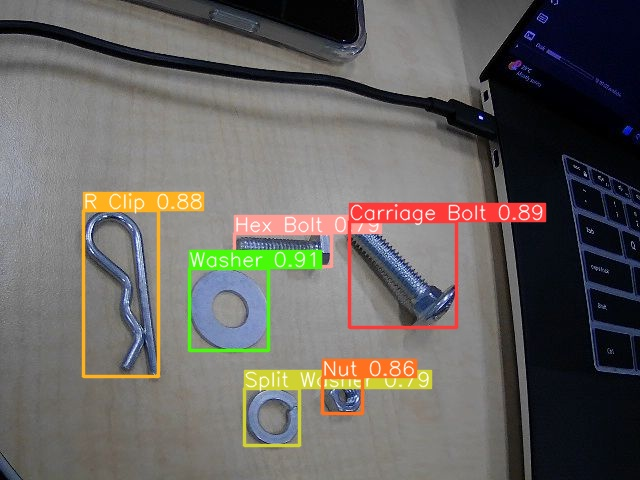

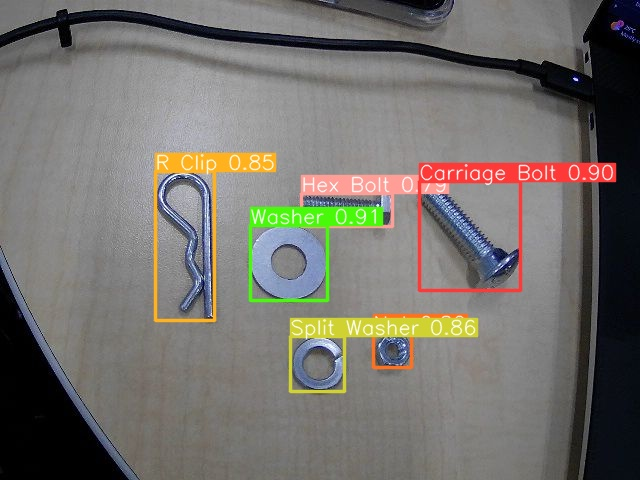

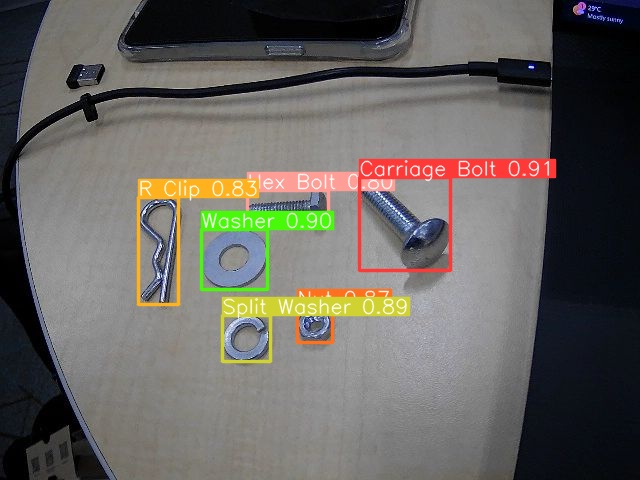

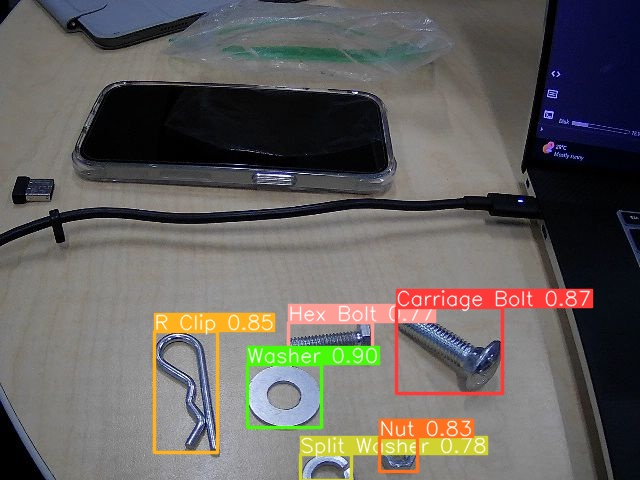

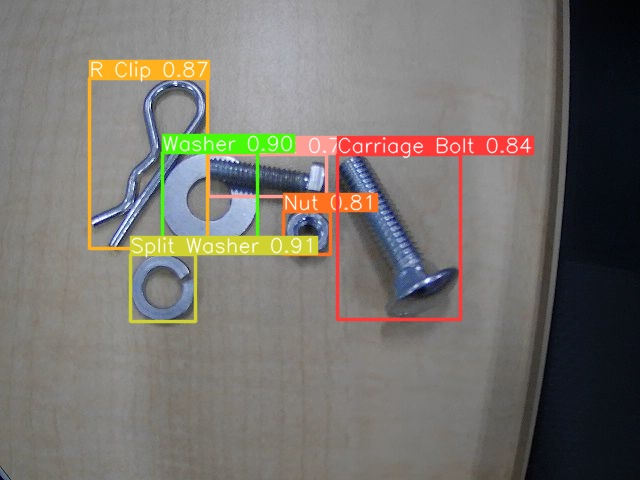

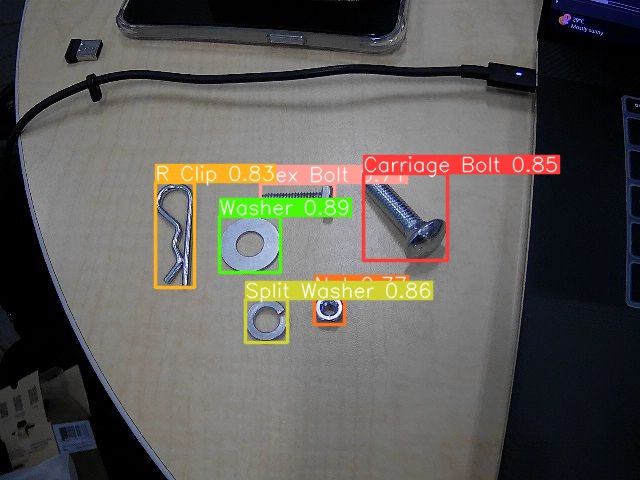

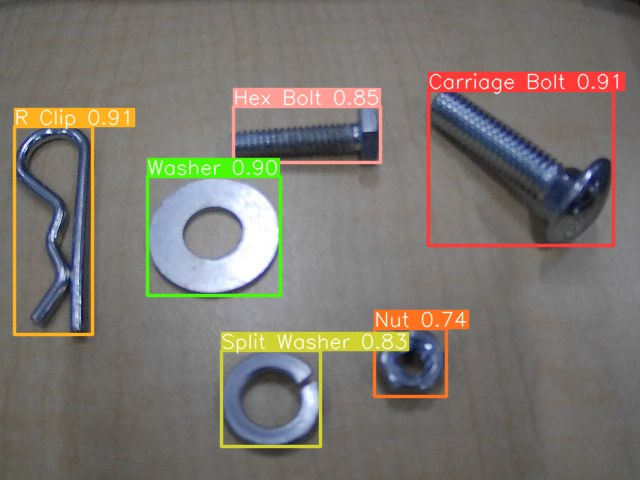

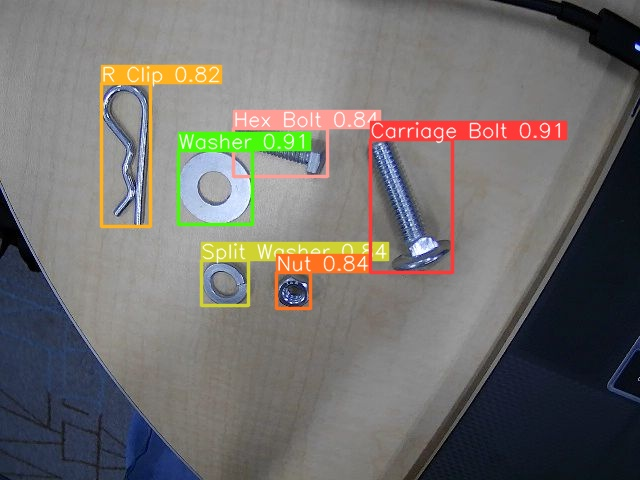

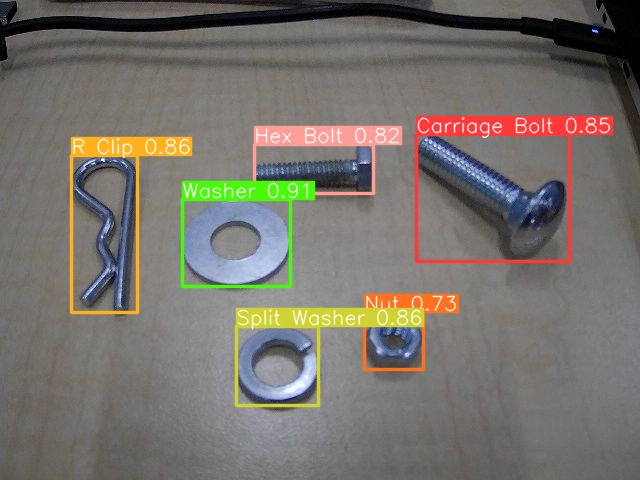

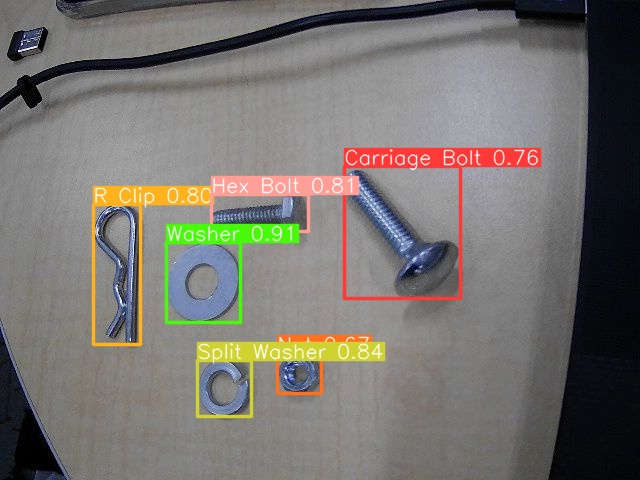

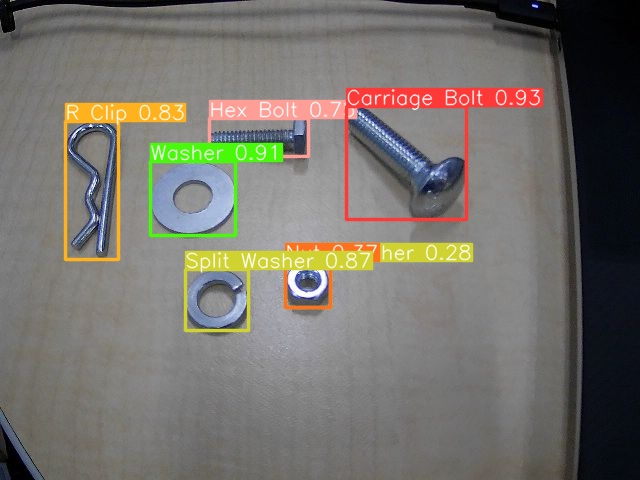

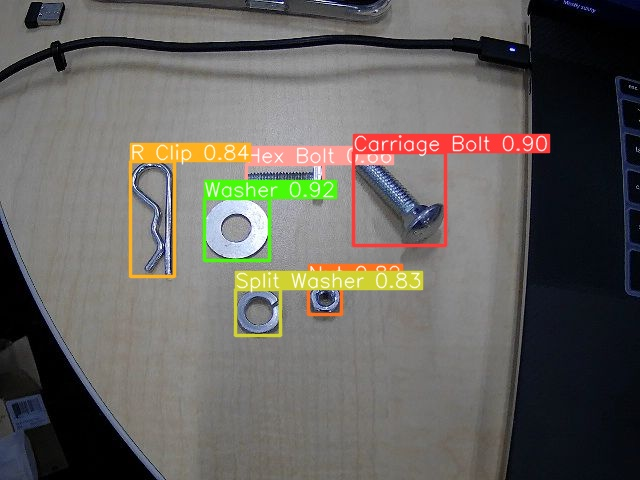

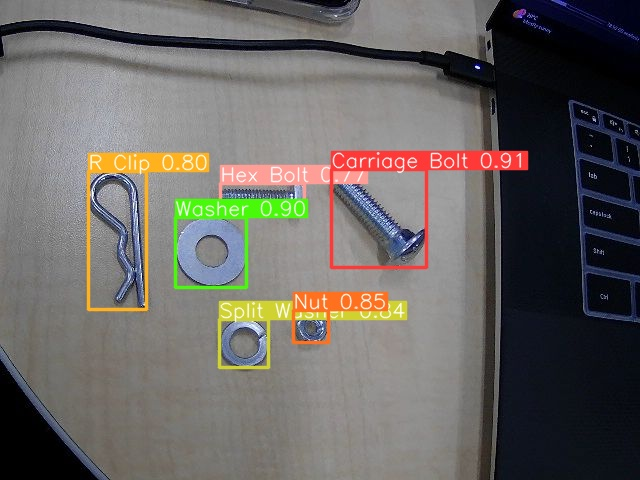

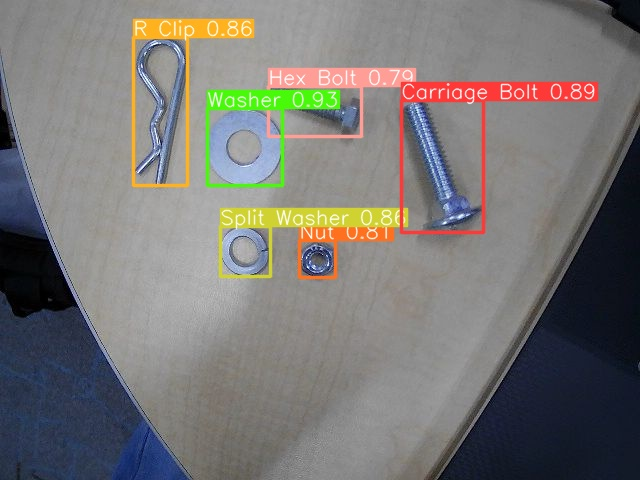

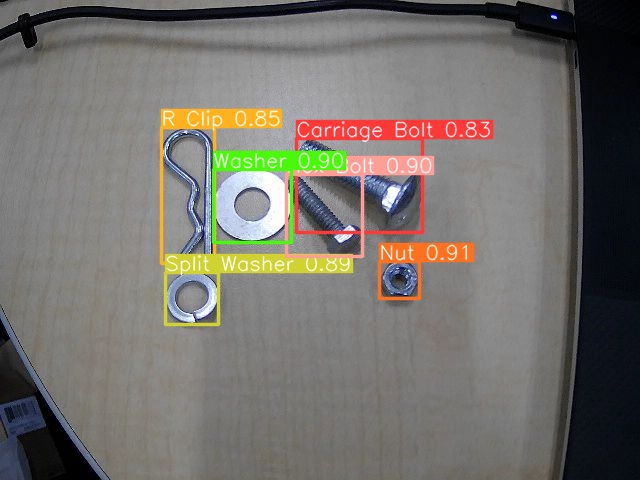

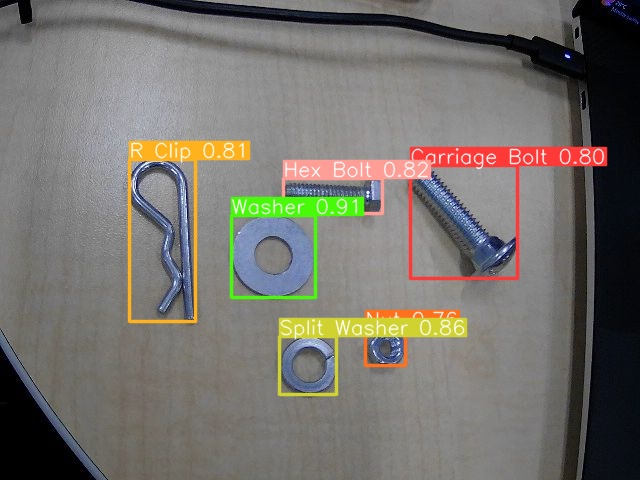

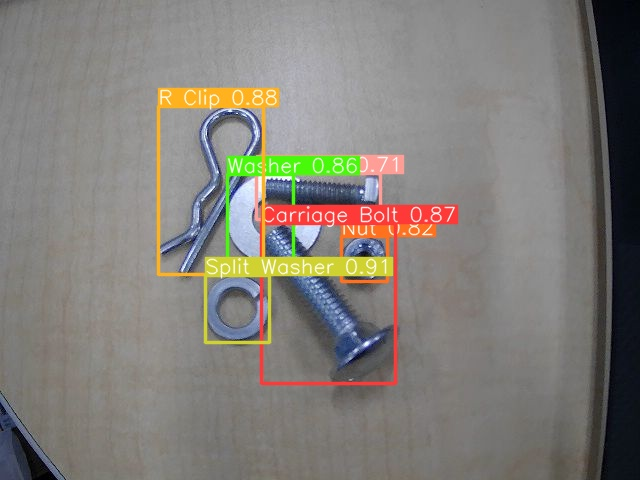

In [15]:
%cd /content/

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

for i in range(20):
  try:
    filename = take_photo('/content/photos/photo'+str(i)+'.jpg')
    print('Saved to {}'.format(filename))

    # Show the image which was just taken.
    display(Image(filename))
  except Exception as err:
    # Errors will be thrown if the user does not have a webcam or if they do not
    # grant the page permission to access it.
    print(str(err))



%cd {HOME}

!yolo task=detect mode=predict model=/content/drive/MyDrive/ECEN250/best.pt conf=0.25 source='/content/photos/' save=True

import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict/*.jpg')[:20]:
      display(Image(filename=image_path, width=600))
      print("\n")

Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 168 layers, 11127906 parameters, 0 gradients, 28.4 GFLOPs

Traceback (most recent call last):
  File "/usr/local/bin/yolo", line 8, in <module>
    sys.exit(entrypoint())
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/cfg/__init__.py", line 445, in entrypoint
    getattr(model, mode)(**overrides)  # default args from model
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/model.py", line 242, in predict
    return self.predictor.predict_cli(source=source) if is_cli else self.predictor(source=source, stream=stream)
  File "/usr/local/lib/python3.10/dist-packages/ultralytics/engine/predictor.py", line 205, in predict_cli
    for _ in gen:  # running CLI inference without accumulating any outputs (do not modify)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/_contextlib.py", line 35, in generator_context
    response = gen.send(None)
  File

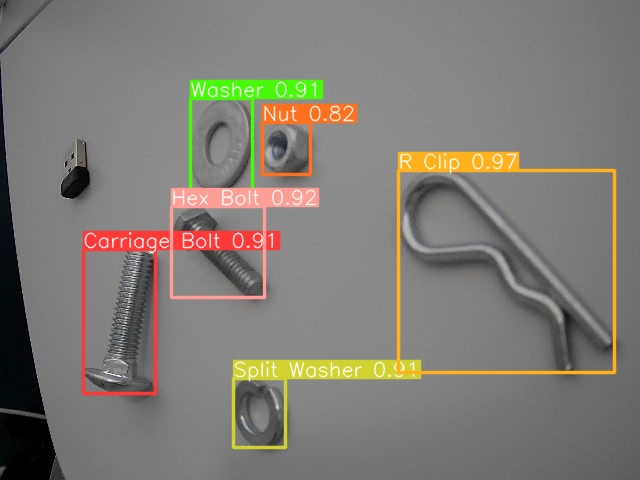

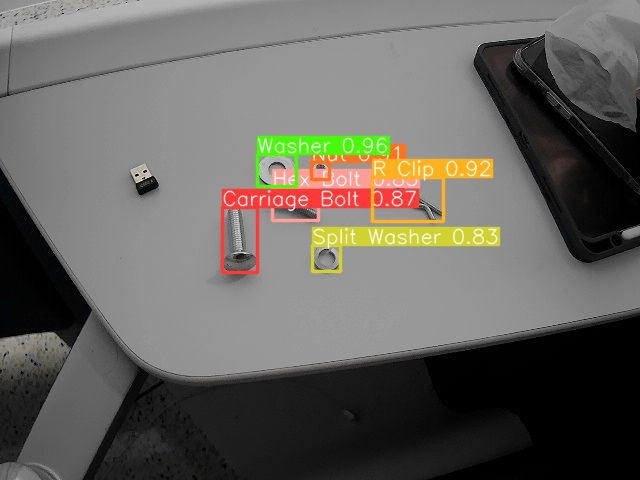

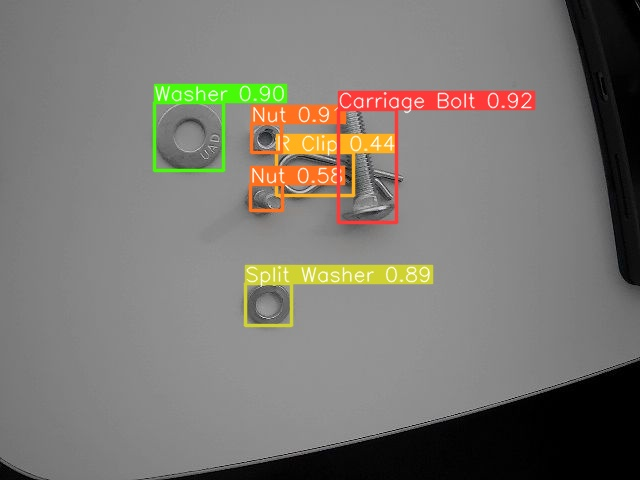

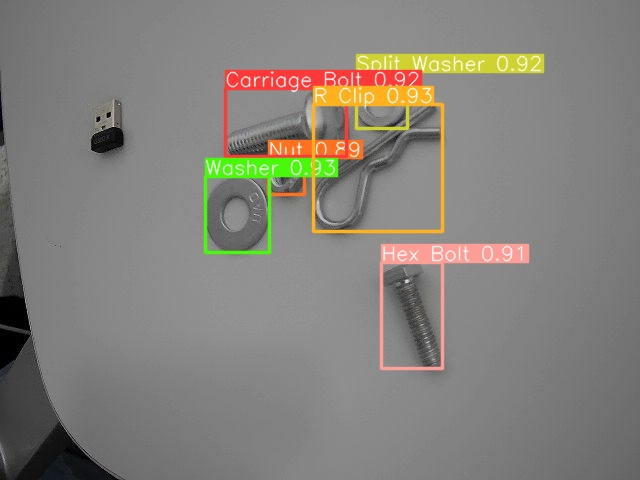

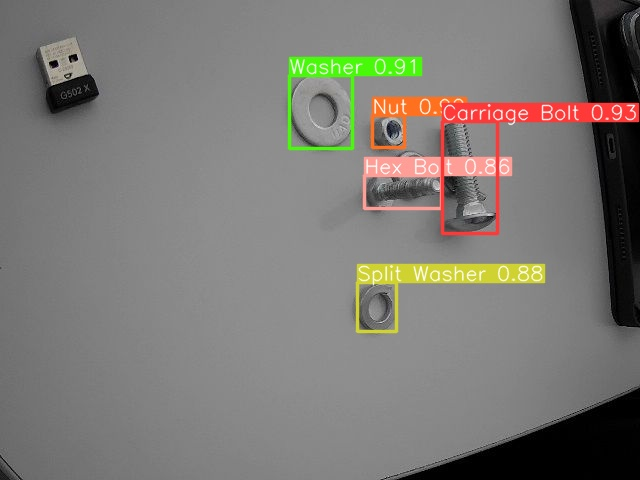

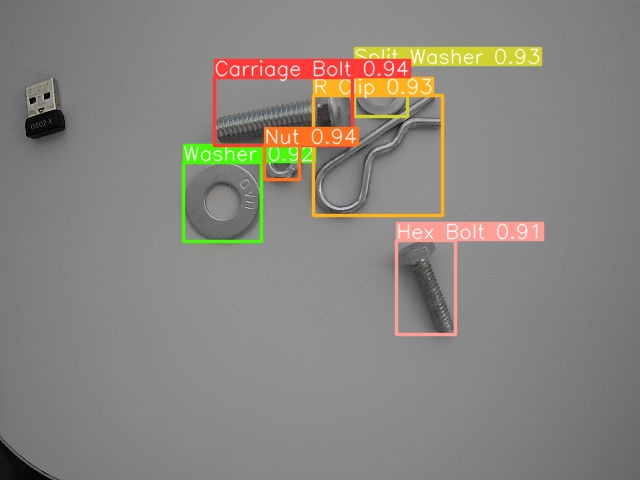

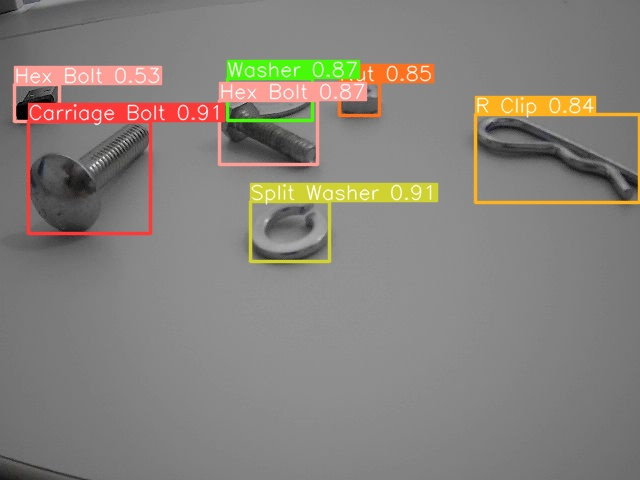

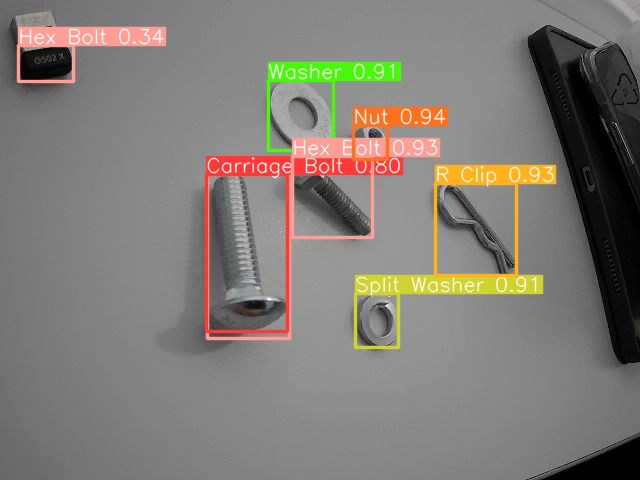

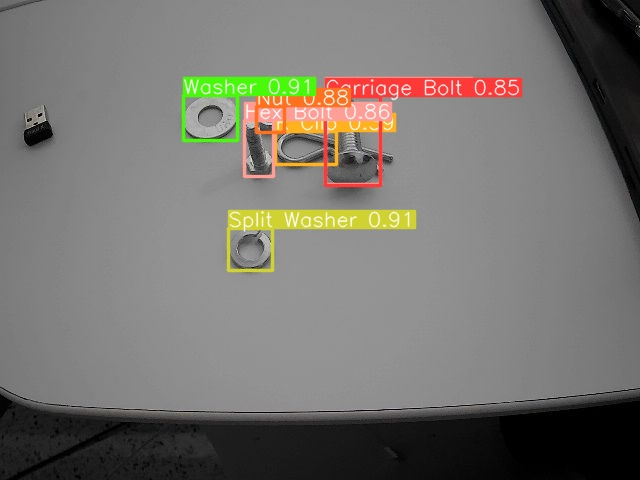

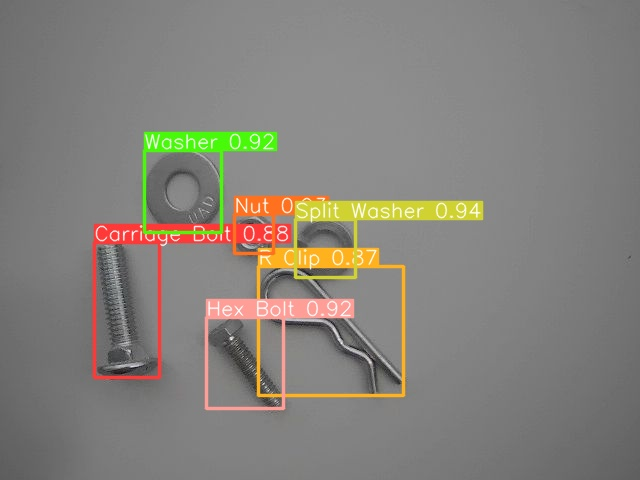

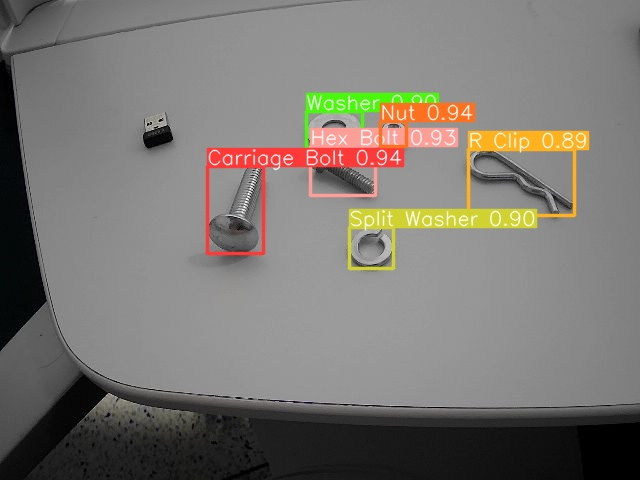

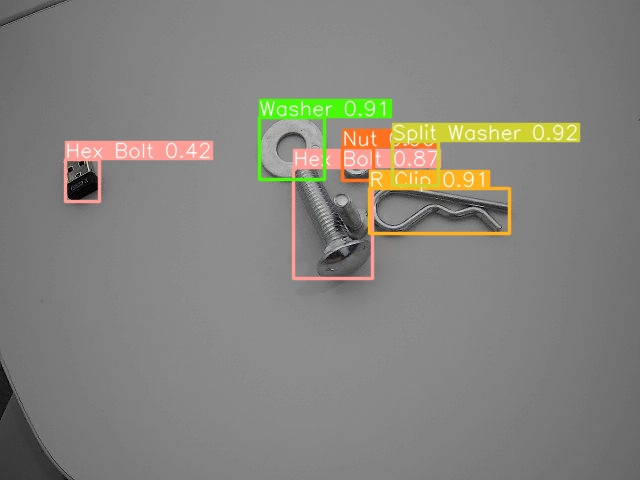

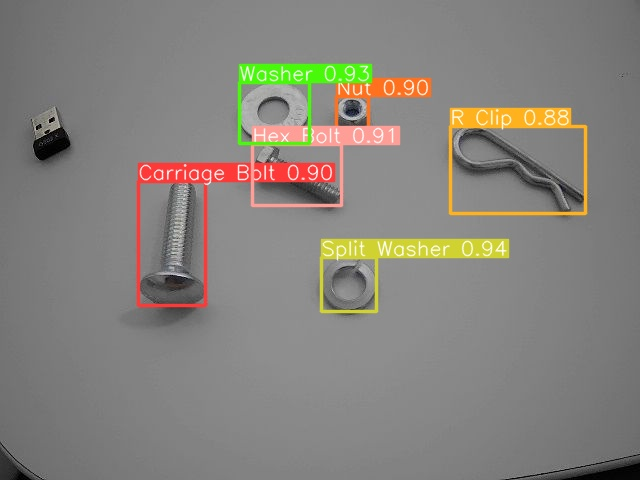

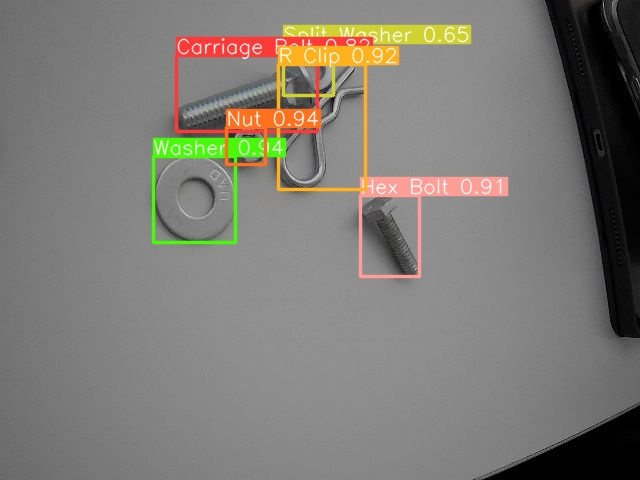

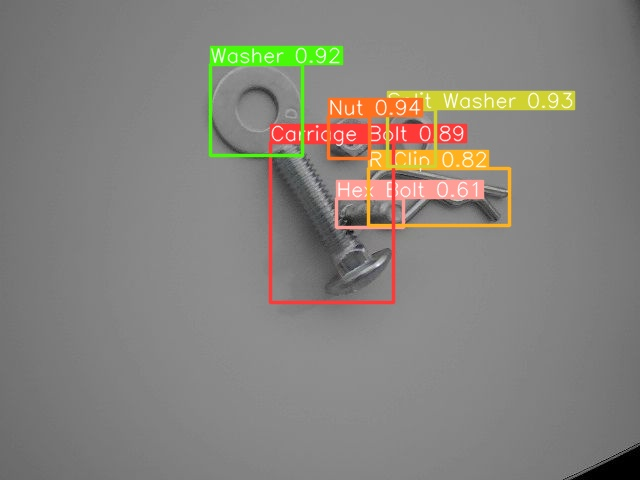

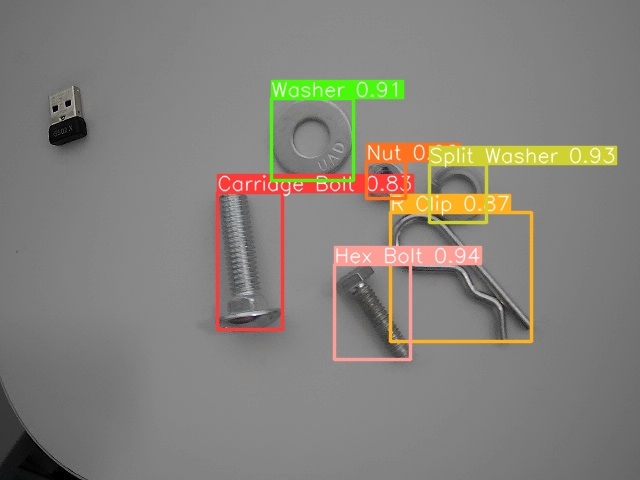

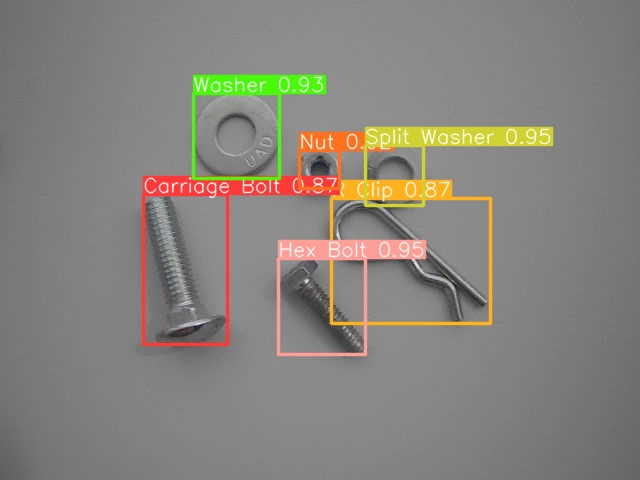

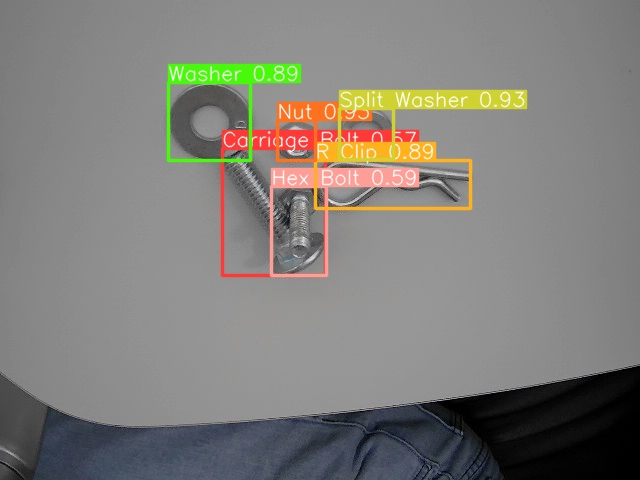

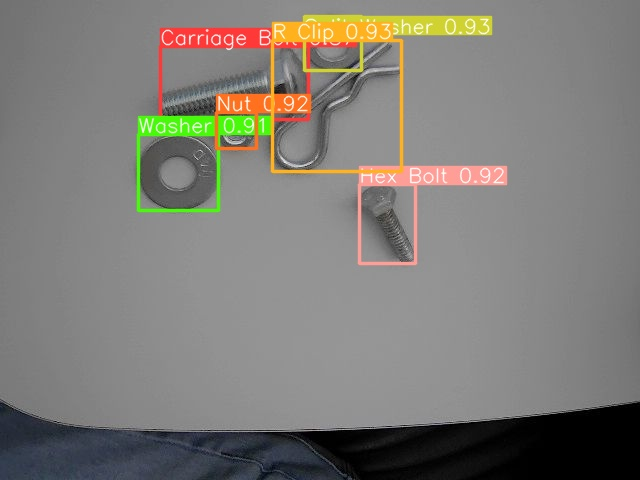

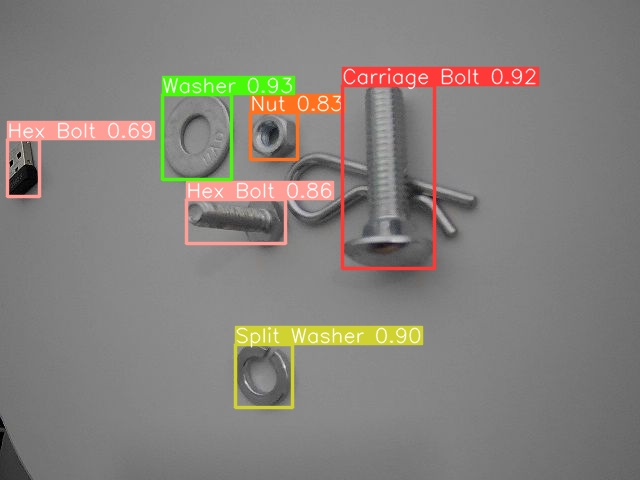

In [ ]:
!yolo task=detect mode=predict model=/content/drive/MyDrive/ECEN250/best.pt conf=0.25 source='/content/photos2/' save=True

import glob
from IPython.display import Image, display

for image_path in glob.glob(f'{HOME}/runs/detect/predict2/*.jpg')[:20]:
      display(Image(filename=image_path, width=600))
      print("\n")

In [2]:
%rm -r /content/photos/

rm: cannot remove '/content/photos/': No such file or directory


In [3]:
%rm -r /content/runs/

rm: cannot remove '/content/runs/': No such file or directory
